# Plot IUPRED3 scores for clouds
Inspect sequences of length up to 600, split them in half by the ratio of bad pLDDTs and color clouds by IUPRED3 score

In [1]:
import glob
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df_with_outliers = pd.concat(dfs)

In [3]:
df_with_outliers = df_with_outliers[df_with_outliers['seq_len'] < 600]
df_with_outliers = df_with_outliers[df_with_outliers['iupred_auc'].notnull()]
df_with_outliers['iupred_auc_normalized'] = df_with_outliers['iupred_auc'] / df_with_outliers['seq_len']
df_with_outliers.nlargest(n=10, columns='iupred_auc_normalized')

uniprot_id  seq_len  domain_count  min_plddt  mean_plddt  median_plddt  \
20510      E9PWP7      378           1.0      40.86     84.6046        89.955   
15009      Q08AU9       97           1.0      25.50     61.7270        64.020   
1794   A0A5K4F6S0       68           0.0      51.87     63.5184        63.695   
9699   A0A0R4ILF4       25           0.0      65.35     94.5168        96.730   
1884       P62947       25           0.0      64.88     94.3656        96.660   
11540  A0A5K4EP43       64           0.0      64.23     79.1627        81.385   
6017   A0A0K0E6Y1       87           0.0      38.51     55.9576        51.840   
3102       X8F7E7       40           0.0      64.02     72.2935        71.890   
5318   A0A0N4URX1      226           0.0      28.62     40.7413        41.270   
7445       Q20693       87           0.0      40.51     49.0501        49.520   

       ratio_bad_plddt  iupred_auc  iupred_plddt_spearman  repeat_6mers_2000  \
20510           0.1534   2730.6999              -0.142760                0.0   
15009           0.7113    157.9724               0.618561                0.0   
1794            0.9118     69.3653               0.080402               41.0   
9699            0.0400     25.4887               0.483846                0.0   
1884            0.0400     25.4887               0.525385                0.0   
11540           0.1406     65.0331               0.565980                0.0   
6017            0.8391     88.3691              -0.669455                0.0   
3102            0.3000     40.3720               0.131895                0.0   
5318            1.0000    228.0693              -0.121998                0.0   
7445            1.0000     87.6582               0.386724                0.0   

       ...  freq_neg_charge  freq_polar  freq_non_polar      IEP  \
20510  ...           0.1190      0.4788          0.2910   5.3808   
15009  ...           0.0515      0.4948          0.2165  10.9208   
1794   ...           0.7353      0.1765          0.0882   4.0500   
9699   ...           0.0000      0.2400          0.0800  12.0000   
1884   ...           0.0000      0.2400          0.0800  12.0000   
11540  ...           0.0625      0.1406          0.2656  11.5293   
6017   ...           0.2874      0.0575          0.0805   6.1834   
3102   ...           0.3000      0.5000          0.0500   4.2359   
5318   ...           0.6637      0.1195          0.1504   4.0500   
7445   ...           0.2414      0.2414          0.1494   5.7570   

       cluster_id_x  cluster_id_y  proteome cluster_id suboptim_compress  \
20510           NaN           NaN     MOUSE        NaN               NaN   
15009           NaN           NaN     MOUSE        NaN               NaN   
1794            NaN           NaN     SCHMA        NaN               NaN   
9699            NaN           NaN     DANRE        NaN               NaN   
1884            NaN           NaN     MOUSE        NaN               NaN   
11540           NaN           NaN     SCHMA        NaN               NaN   
6017            NaN           NaN     STRER        NaN               NaN   
3102            NaN           NaN     MYCUL        NaN               NaN   
5318            NaN           NaN     DRAME        NaN               NaN   
7445            NaN           NaN     CAEEL        NaN               NaN   

      iupred_auc_normalized  
20510              7.224074  
15009              1.628581  
1794               1.020078  
9699               1.019548  
1884               1.019548  
11540              1.016142  
6017               1.015737  
3102               1.009300  
5318               1.009156  
7445               1.007566  

[10 rows x 23 columns]

In [4]:
# Remove outlier
df = df_with_outliers[df_with_outliers['iupred_auc_normalized'] < 1.6]

In [5]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['iupred_auc_normalized'])
print(f'Spearman rank correlation: {"{0:.4f}".format(rho)}')

Spearman rank correlation: 0.5059


In [6]:
%matplotlib notebook
fig = plt.figure()

ax = plt.axes(projection='3d')
p = ax.scatter(df['ratio_bad_plddt'], df['median_plddt'], df['mean_plddt'], c=df['iupred_auc_normalized'], cmap='viridis')
ax.set_xlabel("Ratio bad pLDDT")
ax.set_ylabel("Median pLDDT")
ax.set_zlabel("Mean pLDDT")
fig.colorbar(p, ax=ax)
plt.show()

<IPython.core.display.Javascript object>

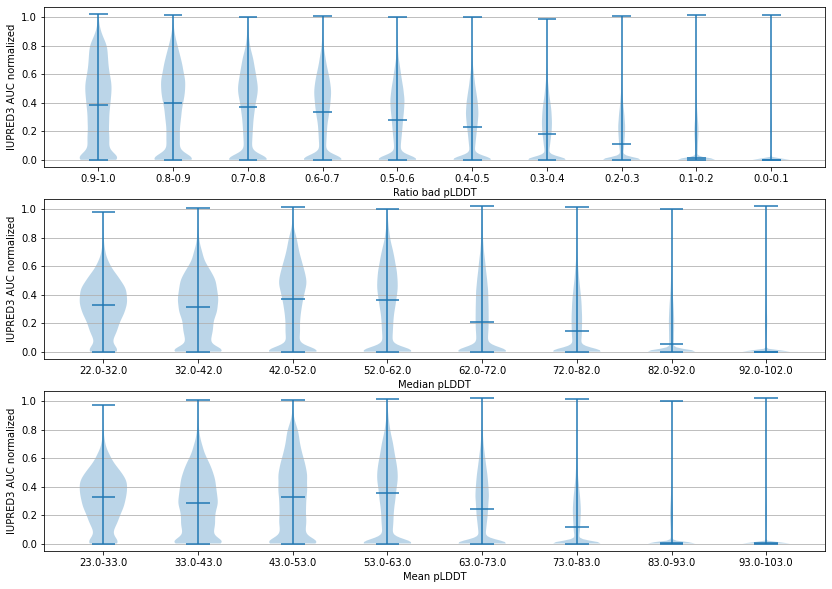

In [6]:
%matplotlib inline
fig, [ax1, ax2, ax3] = plt.subplots(nrows=3, figsize=(14, 10))

def violin_plot(ax, prop, title, bucket_step_size, decimals=0):
    buckets_indices = np.arange(np.floor(df[prop].min()), df[prop].max(), bucket_step_size)
    buckets = [df[df[prop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in buckets_indices]
    ax.violinplot(dataset = [bucket['iupred_auc_normalized'].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel(title)
    ax.set_ylabel('IUPRED3 AUC normalized')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)

violin_plot(ax1, 'ratio_bad_plddt', 'Ratio bad pLDDT', 0.1, decimals=1)
ax1.invert_xaxis()
violin_plot(ax2, 'median_plddt', 'Median pLDDT', 10)
violin_plot(ax3, 'mean_plddt', 'Mean pLDDT', 10)

plt.show()

### Investigate 6mer frequency as fallback for bad IUPRED

In [8]:
df_with_outliers.nlargest(1000, columns=['ratio_bad_plddt']).nsmallest(1000, columns=['iupred_auc'])[['uniprot_id', 'ratio_bad_plddt', 'iupred_auc']].to_csv('../data/alphafold/bad_alphafold_good_iupred.csv', index=None)